**LoRA** makes a small change in the fine-tuning process. Instead of computing gradients for all the entries in W (which is huge), and updating all the parameters, it’s algorithm works as follows:
- Freeze the original parameters W at the start of fine-tuning.
- Decomposes W into two smaller matrices A and B, and update these two small matrices during fine-tuning. The decomposed matrices are significantly smaller in size than the original weight matrix W, and can easily fit into the memory. The decomposition is done in such a way that we can regenerate W from A and B. Basically A and B are LD, so the resulting LI matrix (That it is W) can be composed from A and B
- Once fine-tuning is completed, the smaller matrices A and B get adapted for the specific task.
- The important thing to note here is that the pretrained weights are not changed during this process as they were frozen by LoRA. The question arises now that how do we use the adapted matrices A and B to do the inference on a new input. Previously with normal finetuning/pretraining, if input to the model was x, the output of layer used to be W.x. But after fine-tuning the model with LoRA, the updated inference equation is:

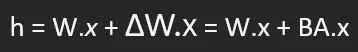

where 𝑥 is the input, 𝑊 represents model parameters, 𝐵 and 𝐴 represent low-rank adapters trained during LoRA fine-tunin

The amount of memory saved depends on the rank r, a hyperparameter. For instance, if ΔW has 10,000 rows and 20,000 columns, it holds 200,000,000 parameters. Choosing A and B with r=8, A would have 10,000 rows and 8 columns, and B would have 8 rows and 20,000 columns, resulting in 10,000×8 + 8×20,000 = 240,000 parameters, which is approximately 830 times fewer than 200,000,000.

In [ ]:
!pip install peft boto3 bitsandbytes -q

In [ ]:
import torch

if torch.device.is_cuda_available():
    print("Using CUDA cores")
else
    print("Using CPU cores")
    
print(f"PyTorch version: {torch.__version__}")

### The rank in LoRa Fine tuning
A higher rank means a greater number of trainable parameters in our model, making fine-tuning more memory intensive. However, higher ranks retain more information from the original weight matrix, as the decomposed matrices themselves are large and capture most of the essence of W (i.e., the model becomes more expressive). We can say that, as the rank increases, LORA essentially converges toward normal fine-tuning.
### Alpha in LoRa
A higher “alpha” would place more emphasis on the low-rank structure or regularization, while a lower “alpha” would reduce its influence, making the model rely more on the original parameters. Adjusting “alpha” helps in striking a balance between fitting the data and preventing overfitting by regularizing the model.

As a rule of thumb, it’s usually common to choose an alpha that is twice as large as the rank when fine-tuning LLMs (note that this is different when working with diffusion models).

In [ ]:
from peft import LoraConfig
import os

### A sweet pot for LoRa is r=8
lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
    lora_alpha=16
)

In [ ]:
import getpass
 
try:
    p = getpass.getpass()
except Exception as error:
    print('ERROR', error)
else:
    print('Hf token set succesfully')
    os.environ["HF_TOKEN"]= p

In [ ]:
import os

s3_endpoint = os.environ["AWS_S3_ENDPOINT"]
s3_secret = os.environ["AWS_SECRET_ACCESS_KEY"]
s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]

In [ ]:
import boto3
from tqdm import tqdm
import json
## Load dataset
if s3_access_key is None: raise TypeError(f"'S3_ACCESS_KEY_ID' env variable is not set")
if s3_secret is None: raise TypeError(f"'S3_SECRET_ACCESS_KEY' env variable is not set")

# Enter the bucket and model name
bucket_name = input("Enter bucket name:")
model_name = input("Enter model name:")

if bucket_name == "": raise TypeError(f"'bucket_name' input variable is empty")
if model_name == "": raise TypeError(f"'model_name' input variable is empty")

full_path = f"{bucket_name}/datasets/labeled/gemma/{model_name}"

print("\nConnecting to S3 in path: "+ full_path)

# Initialize session and client with boto3
session = boto3.session.Session()
s3_client = session.client('s3',
                           region_name='nyc3',
                           endpoint_url=s3_endpoint,
                           aws_access_key_id=s3_access_key,
                           aws_secret_access_key=s3_secret
                          )
# Initialize paginator
paginator=s3_client.get_paginator('list_objects_v2')
pages=paginator.paginate(Bucket=bucket_name,Prefix=f"datasets/labeled/gemma/{model_name}")
i=0
dataset=[]
for page in pages:
    page_objects = page.get('Contents', [])
    for obj in tqdm(page_objects,desc="Loading dataset"):
        data = s3_client.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        content =(data['Body'].read()).decode("utf-8")
        if(i>0 and type(content) is str):
            annotation = json.loads(content)
            results=annotation.get("result")
            if(len(results) <= 0):
                continue
            data = annotation.get("task").get("data")
            instruction= data.get("input")
            context = data.get("input2")
            response = results[0].get("value").get("text")[0]
            dataset.append(
                {
                    "instruction":instruction,
                    "context":context,
                    "response":response
                }
            )
        i+=1

In [ ]:
import pandas as pd
pd.__version__

In [ ]:
## Parse to dataframe from pandas and show first 3
df = pd.DataFrame(dataset)
df.head(3)

### Check how is performing the base model without PEFT 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "google/gemma-2b"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id, token=os.environ['HF_TOKEN'])
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0}, token=os.environ['HF_TOKEN'])

In [ ]:
sample = df.iloc[0]
instruction = sample["instruction"]
context = sample["context"]
print("Context:\n")
print(f"{context}\n")

print("Instructions:\n")
print(f"{instruction}\n")

In [ ]:
text = f"Instructions:{instruction}\nContext:{context}\nResponse:"
device = "cuda:0"
inputs = tokenizer(text, return_tensors="pt").to(device)

outputs = model.generate(**inputs,max_length=1000)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
print(f"EXPECTED ANSWER:\n")
print(f"{sample['response']}\n")

print(f"ANSWER:")
print(response)

In [ ]:
import transformers
from trl import SFTTrainer

def formatting_func(example):
    ## Format text according dataset
    text = f"Instructions:{example["instruction"]}\nContext:{example["context"]}\nResponse:{example["response"]}<eos>"
    return [text]

trainer = SFTTrainer(
    model=model,
    train_dataset=df,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=10,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    ),
    peft_config=lora_config,
    formatting_func=formatting_func,
)
trainer.train()